# Ramsey-Cass-Koopmans model

Ramsey model from Chapter 2 of D. Romer's *Advanced Economics* looks as follows...

\begin{align}
    \dot{k}(t) =& k(t)^{\alpha} - c(t) - (g + n + \delta)k(t),\\
    \dot{c}(t) =& \Bigg[\frac{1}{\theta} \bigg[\alpha k(t)^{\alpha - 1} - \delta - \rho - \theta g\bigg]\Bigg]c(t)
\end{align}
...with boundary conditions...
\begin{align}
    k(0) =& k_0 \\
    lim_{t\rightarrow \infty} c(t) =& c^*
\end{align}

...where...

* Elasticity of output with respect to catpial: $0 < \alpha < 1$
* Coefficient of relative risk aversion: $0 < \theta$
* Discount rate: $0 < \rho$
* Breakeven investment: $0 < g + n + \delta$
* Convergent lifetime utility: $0 < \rho - n - (1 - \theta)g$

Note that we are assuming two things...

1. Cobb-Douglas production
2. Constant Relative Risk Aversion (CRRA) preferences



In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import sympy as sym

import pycollocation

In [3]:
# define some variables
t, k, c = sym.symbols("t, k, c")

In [4]:
# define some production parameters
alpha, delta = sym.symbols("alpha, delta")

# define growth rates
g, n = sym.symbols("g, n")

# define some preference parameters
theta, rho = sym.symbols("theta, rho")

In [5]:
# user defined extensive production function
def extensive_output(A, K, L, **params):
    """Output is a function of technology, A, capital, K, and labor, L."""
    alpha = params['alpha']
    return K**alpha * (A * L)**(1 - alpha)

def intensive_output(k, **params):
    """
    Intensive output is a function of capital (per unit effective labor)
    and model parameters.
    
    """
    return extensive_output(1, k, 1, **params) 

# call with symbolic input and get symbolic result!
print intensive_output(k, alpha=alpha)

k**alpha


In [6]:
# call with numeric input and get numeric result...
print intensive_output(10.0, alpha=0.33)

2.1379620895


In [7]:
# also works with arrays!
ks = np.linspace(0, 100, 10)
print intensive_output(ks, alpha=0.33)

[ 0.          2.21360421  2.7825301   3.18089978  3.49767755  3.76495746
  3.99843357  4.20709506  4.39662746  4.5708819 ]


In [8]:
# define a flow utility function
def flow_utility(c, **params):
    """Flow utility from consumption (per unit effective labor)."""
    theta = params['theta']
    return (c**(1 - theta) - 1) / (1 - theta)

# symbolic inputs give symbolic outputs...
print flow_utility(c, theta=theta)

(c**(-theta + 1) - 1)/(-theta + 1)


In [9]:
# also works with scalars
print flow_utility(10.0, theta=3.5)

0.398735088936


In [10]:
# also works with arrays
cs = np.linspace(2.0, 10.0, 5)
print flow_utility(cs, theta=2.5)

[ 0.43096441  0.58333333  0.62130575  0.63720388  0.64558482]


In [11]:
def actual_investment(k, c, **params):
    """Return investment (per unit effective labor)."""
    return intensive_output(k, **params) - c

def break_even_investment(k, delta, g, n, **params):
    """
    Return level of investment (per unit effective labor) required
    to maintain current level of capital (per unit effective labor).
    
    """
    return (g + n + delta) * k

In [12]:
# define the equation of motion for capital (per unit effective labor)
def equation_motion_capital(k, c, delta, g, n, **params):
    """Equation of motion for capital (per unit effective labor)."""
    k_dot = (actual_investment(k, c, **params) -
             break_even_investment(k, delta, g, n, **params))
    return k_dot

# symbolic inputs yield symbolic output!
print equation_motion_capital(k, c, alpha=alpha, delta=delta, g=g, n=n)

-c - k*(delta + g + n) + k**alpha


In [13]:
# also works for scalars...
equation_motion_capital(10.0, 3.0, alpha=0.33, delta=0.04, g=0.02, n=0.02)

-1.6620379104977678

In [14]:
# also works for arrays (useful for plotting!)...
ks = np.linspace(0, 5.0, 10)
equation_motion_capital(ks, 3.0, alpha=0.33, delta=0.04, g=0.02, n=0.02)

array([-3.        , -2.2207615 , -2.05350841, -1.94971935, -1.87629067,
       -1.82128016, -1.77884806, -1.74564948, -1.71956885, -1.69917316])

In [15]:
def marginal_product_capital(k, **params):
    """Marginal product of capital (per unit effective labor)."""
    return sym.diff(intensive_output(k, **params), k, 1)
    
# symbolic input yields symbolic output
print marginal_product_capital(k, alpha=alpha)

alpha*k**alpha/k


In [16]:
def relative_risk_aversion_coef(c, **params):
    """Returns the coefficient of relative risk aversion."""
    u = flow_utility(c, **params)
    crra = -((c * sym.diff(u, c, 2)) / sym.diff(u, c, 1))
    return crra

# should simplify to theta with CRRA preferences
assert(relative_risk_aversion_coef(c, theta=theta).simplify() == theta)

In [17]:
def elasticity_intertemporal_substitution(c, **params):
    """
    Elasticity of intertemporal substitution is reciprical of the
    coefficient of relative risk aversion.
    
    """
    epsilon = 1 / relative_risk_aversion_coef(c, **params)
    return epsilon

In [18]:
def consumption_euler_equation(k, c, delta, g, rho, **params):
    """Consumption Euler equation."""
    mpk = marginal_product_capital(k, **params)
    epsilon = elasticity_intertemporal_substitution(c, **params)
    c_dot = (epsilon * (mpk - delta - rho) - g) * c
    
    return c_dot

In [19]:
# create a dictionary representing the RHS of our model
k_dot = equation_motion_capital(k, c, alpha=alpha, delta=delta, g=g, n=n)
c_dot = consumption_euler_equation(k, c, alpha=alpha, delta=delta,
                                   rho=rho, theta=theta, g=g, n=n)
rhs = {'k': k_dot, 'c': c_dot}
print rhs

{'k': -c - k*(delta + g + n) + k**alpha, 'c': c*(c**(-theta + 1)*c**(theta - 1)*(alpha*k**alpha/k - delta - rho)/theta - g)}


## Boundary conditions
Now we need to derive the steady state value for capital and consumption (per unit effective labor)...
\begin{align}
    0 =& k(t)^{\alpha} - c(t) - (g + n + \delta)k(t),\\
    0 =& \Bigg[\frac{1}{\theta} \bigg[\alpha k(t)^{\alpha - 1} - \delta - \rho - \theta g\bigg]\Bigg]c(t)
\end{align}

Here we go, first for capital,...
\begin{align}
    0 =& \Bigg[\frac{1}{\theta} \bigg[\alpha k(t)^{\alpha - 1} - \delta - \rho - \theta g\bigg]\Bigg]c(t) \\
    0 =& \alpha k(t)^{\alpha - 1} - \delta - \rho - \theta g \\
    \alpha k(t)^{\alpha - 1} =& \delta + \rho + \theta g \\
    k(t)^{\alpha - 1} =& \frac{\delta + \rho + \theta g}{\alpha} \\
    k^* =& \Bigg(\frac{\delta + \rho + \theta g}{\alpha}\Bigg)^{\frac{1}{\alpha - 1}} \\
    k^* =& \Bigg(\frac{\alpha}{\delta + \rho + \theta g}\Bigg)^{\frac{1}{1 - \alpha}}
\end{align}

In [20]:
# user-defined function!
def steady_state_capital(delta, g, n, rho, alpha, theta):
    """Equilibrium value of capital (per unit effective labor)."""
    return (alpha / (delta + rho + theta * g))**(1 / (1 - alpha))

# call the function with symbolic parameters...and get a symbolic result!
print steady_state_capital(delta, g, n, rho, alpha, theta)

(alpha/(delta + g*theta + rho))**(1/(-alpha + 1))


...next we do the same for consumption...

\begin{align}
    0 =& k^{*\alpha} - c^* - (g + n + \delta)k^* \\
    c^* =& k^{*\alpha} - (g + n + \delta)k^*
\end{align}

In [22]:
def steady_state_capital_locus(k, delta, g, n, **params):
    """
    Locus of points (k, c) such that :math:`\dot{k}=0`.
    
    Function returns the level of consumption (per unit
    effective labor) required in order to maintain a given
    level of capital (per unit effective labor).
    
    """
    locus = (intensive_output(k, **params) -
             break_even_investment(k, delta, g, n, **params))
    return locus
    
def steady_state_consumption(delta, g, n, rho, **params):
    """Equilibrium value for consumption (per unit effective labor)."""
    k_star = steady_state_capital(delta, g, n, rho, **params)
    c_star = steady_state_capital_locus(k_star, delta, g, n, **params)
    return c_star

# call function with symbolic parameters...get a symbolic result!
print steady_state_consumption(delta, g, n, rho, alpha=alpha, theta=theta)

-(alpha/(delta + g*theta + rho))**(1/(-alpha + 1))*(delta + g + n) + ((alpha/(delta + g*theta + rho))**(1/(-alpha + 1)))**alpha


In [23]:
# finally we need to define some parameters...
params = {'alpha': 0.33, 'delta': 0.04, 'theta': 1.05, 'rho': 0.05,
          'g': 0.02, 'n': 0.02}

In [24]:
# call function with numeric inputs and get a numeric result!
steady_state_consumption(**params)

1.303501661180578

In [25]:
# define some boundary conditions
k0 = 1.0
c_star = steady_state_consumption(alpha=alpha, delta=delta, theta=theta,
                                  rho=rho, g=g, n=n)

bcs = {'lower': [k - k0],
       'upper': [c - c_star]}
print bcs

{'upper': [c + (alpha/(delta + g*theta + rho))**(1/(-alpha + 1))*(delta + g + n) - ((alpha/(delta + g*theta + rho))**(1/(-alpha + 1)))**alpha], 'lower': [k - 1.0]}


## Using pyCollocation

In [26]:
model = pycollocation.SymbolicBoundaryValueProblem(dependent_vars=['k', 'c'],
                                                   independent_var='t',
                                                   rhs=rhs,
                                                   boundary_conditions=bcs,
                                                   params=params)

In [27]:
solver = pycollocation.OrthogonalPolynomialSolver(model)

In [28]:
# now this works for numerical values as well!
steady_state_capital(**params)

5.084580947867504

In [29]:
# define our domain of approximation
domain = [0.0, 100.0]

# initial guess for capital
N = 1000
ts = np.linspace(domain[0], domain[1], N)
ks = steady_state_capital(**params) - (steady_state_capital(**params) - k0) * np.exp(-ts)
cs = np.log(ks)

def initial_polynomial(ts, xs, deg, domain):
    """Eventually need some to link to underlying basis functions!"""
    return np.polynomial.Chebyshev.fit(ts, ks, deg, domain)

def initial_coefs(ts, ks, cs, deg, domain):
    """Return dictionary of coefs."""
    capital = initial_polynomial(ts, ks, deg, domain)
    consumption = initial_polynomial(ts, cs, deg, domain)
    coefs = {'k': capital.coef, 'c': consumption.coef}
    return coefs

In [30]:
coefs_guess = initial_coefs(ts, ks, cs, 35, domain) 
solver.solve(kind="Chebyshev",
             coefs_dict=coefs_guess,
             domain=domain)

In [31]:
solver.result.x

array([  4.37225405e+00,   1.29407760e+00,  -9.72862387e-01,
         6.08921292e-01,  -3.18201558e-01,   1.37285311e-01,
        -4.62850602e-02,   9.22882156e-03,   2.25265028e-03,
        -4.07400457e-03,   3.21212000e-03,  -2.07493833e-03,
         1.24105453e-03,  -7.22117266e-04,   4.18592261e-04,
        -2.44435831e-04,   1.44396564e-04,  -8.63551432e-05,
         5.22449115e-05,  -3.19390960e-05,   1.97071578e-05,
        -1.22605018e-05,   7.68428915e-06,  -4.84844391e-06,
         3.07792569e-06,  -1.96514557e-06,   1.26163055e-06,
        -8.14606070e-07,   5.29424466e-07,  -3.47071441e-07,
         2.30580740e-07,  -1.56776432e-07,   1.10978890e-07,
        -8.39515496e-08,   4.59631210e-08,  -9.06485057e-09,
         1.17873943e+00,   2.28498625e-01,  -1.76366595e-01,
         1.16303877e-01,  -6.68076608e-02,   3.42707361e-02,
        -1.62089828e-02,   7.36702585e-03,  -3.37782840e-03,
         1.63268450e-03,  -8.50106911e-04,   4.74261609e-04,
        -2.78167064e-04,

In [32]:
# now create a visualizer for plot the solution...
visualizer = pycollocation.Visualizer(solver)

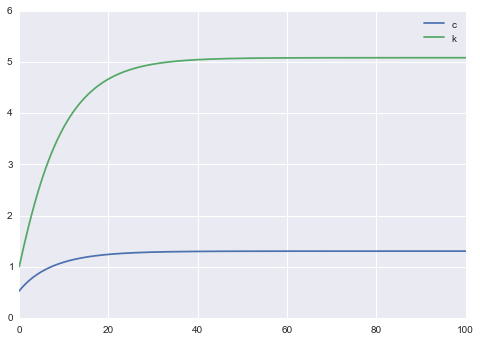

In [33]:
# plot the solution
visualizer.interpolation_knots = np.linspace(domain[0], domain[1], N)
visualizer.solution.plot()
plt.show()

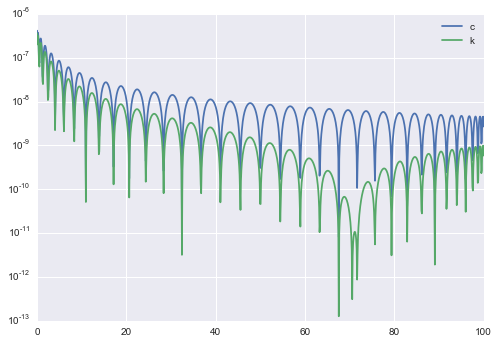

In [34]:
# plot the normalized residuals (they should be small everywhere!)
visualizer.normalized_residuals.plot(logy=True)
plt.show()